In [8]:
from matminer.featurizers.composition import ElementFraction
from pymatgen.symmetry.groups import SpaceGroup
from pymatgen.core import Composition
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import ast 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import optuna

---- 
Initial Tests for getting compositional descriptors and Spacegroup Numbers.

In [25]:
df = pd.read_csv('../Data/1_MatDX/MatDX_EF.csv')

df.head()

,formula,space_group,structure,id,formation_energy
0,Ni4Ta6,R-3c,"[{'data': {'a': [-6.910143e-10, 0, 0], 'b': [3...",PN_MCKVEQNTJFRUHOURCR2HCEB35KDFRETL,{'reference': {'Ni': 'https://nomad-lab.eu/pro...
1,Mn4Sb2,I4_1/amd,"[{'data': {'a': [-1.87778212e-10, 1.87604249e-...",PN_FGGHB2NFWUCYD3YZO4FWN3QVOKCTVI6K,{'reference': {'Mn': 'https://nomad-lab.eu/pro...
2,Ir2Na2,Imma,"[{'data': {'a': [-1.36776653e-10, 2.60817299e-...",PN_BAO7ZSBZZCMA7PH7QMR7WLDI72GOELND,{'reference': {'Na': 'https://nomad-lab.eu/pro...
3,MoSm,R-3m,"[{'data': {'a': [1.65820251e-10, 9.57363439999...",PN_4YR2JLVZHJLC3F2TYPTOVDBJJ52C6XIE,{'reference': {'Mo': 'https://nomad-lab.eu/pro...
4,Sn17P12,I-43m,"[{'data': {'a': [-5.563178910000001e-10, 5.563...",PN_H6P36AVAKDU244QNQGGCJ7YLC4A4F2YE,{'reference': {'P': 'https://nomad-lab.eu/prod...


In [27]:
df.iloc[0]['structure']

"[{'data': {'a': [-6.910143e-10, 0, 0], 'b': [3.455072e-10, -5.984361000000001e-10, 0], 'c': [-3.455072e-10, 1.994788e-10, 3.8393110000000003e-10], 'atoms': [{'x': -3.45507990183523e-10, 'y': -1.9947900244761103e-10, 'z': 7.9504002988613e-11, 'element': 'Ni'}, {'x': -6.9101497659279e-10, 'y': 7.349320005927056e-18, 'z': 1.1246100950784702e-10, 'element': 'Ni'}, {'x': -4.0564010241193595e-18, 'y': -3.989569981570961e-10, 'z': 2.71471008087482e-10, 'element': 'Ni'}, {'x': -3.4550799589121803e-10, 'y': -1.99478979769825e-10, 'z': 3.0442601432568504e-10, 'element': 'Ni'}, {'x': -1.9145199616975595e-10, 'y': -3.989570119487071e-10, 'z': 9.598300151934901e-11, 'element': 'Ta'}, {'x': -5.952883059087111e-10, 'y': -2.3315500026858307e-10, 'z': 9.598300151934901e-11, 'element': 'Ta'}, {'x': -2.4978099508394904e-10, 'y': 3.3676009160126e-11, 'z': 9.598300919797101e-11, 'element': 'Ta'}, {'x': -9.5726999517115e-11, 'y': -1.6580197857073206e-10, 'z': 2.8794801401580905e-10, 'element': 'Ta'}, {'x':

In [14]:
def concatenate_lists(*lists):
    
    return  [item for lst in lists for item in lst]


def get_properties(row):

    data = ast.literal_eval(row['structure'])
    lattice_data = data[0]['data']
    
    lat_a, lat_b, lat_c = lattice_data['a'], lattice_data['b'], lattice_data['c']
    
    volume = abs(np.dot(lat_a, np.cross(lat_b, lat_c))) * 1e30
    e_f = ast.literal_eval(row['formation_energy'])['value']
    
    
    sg = SpaceGroup(row['space_group']).int_number
    
    return (volume, len(lattice_data['atoms']), sg, e_f)


def parity_plots(y_train, y_pred_train, y_test, y_pred):
    # Set up a side-by-side plot with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Define min and max for the perfect prediction line across both plots
    min_val = min(y_train.min(), y_test.min())
    max_val = max(y_train.max(), y_test.max())

    # Training set parity plot
    ax1.scatter(y_train, y_pred_train, alpha=0.6, color="blue")
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)  # Perfect prediction line
    ax1.set_xlabel("Actual Values (Training)")
    ax1.set_ylabel("Predicted Values (Training)")
    ax1.set_title("Training Set Parity Plot")
    ax1.grid(True)

    # Test set parity plot
    ax2.scatter(y_test, y_pred, alpha=0.6, color="green")
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)  # Perfect prediction line
    ax2.set_xlabel("Actual Values (Test)")
    ax2.set_ylabel("Predicted Values (Test)")
    ax2.set_title("Test Set Parity Plot")
    ax2.grid(True)

    # Show the combined plot
    plt.tight_layout()
    plt.show()

In [24]:
df

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,target
Ni4Ta6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,158.766223,10.0,167.0,1.017402
Mn4Sb2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93.088055,6.0,141.0,2.975885
Ir2Na2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,76.498006,4.0,74.0,1.924482
MoSm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,44.216593,2.0,166.0,1.022825
Sn17P12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,688.698397,29.0,217.0,6.236779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FeYb3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,112.547273,4.0,221.0,1.349119
Cu12Ge12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,366.109991,24.0,57.0,3.838551
Al16Ge8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,435.789009,24.0,227.0,4.803874
Pt2Th2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,99.471142,4.0,63.0,-4.940262


In [20]:
check

0           0.000000
1           0.000000
2           0.000000
3           0.000000
4           0.000000
             ...    
117         0.000000
118       158.766223
119        10.000000
120       167.000000
target      1.017402
Name: Ni4Ta6, Length: 122, dtype: float64

In [15]:
descriptors = {}
target_property = {}

featurizer = ElementFraction()

for index, row in df.iterrows():
    
    try:
        volume, num_atoms, sg, e_f = get_properties(row)
        
        formula = row['formula']
        
        composition = Composition(formula)
        
        descriptor = featurizer.featurize(composition)
        
        descriptors[formula] = concatenate_lists(descriptor, [volume, num_atoms, sg])
        target_property[formula] = e_f
        
    except: 
        # print(row)
        pass
        
print('The structure data are missing for :', df.count()['formula']- len(target_property.keys()))

The structure data are missing for : 2018


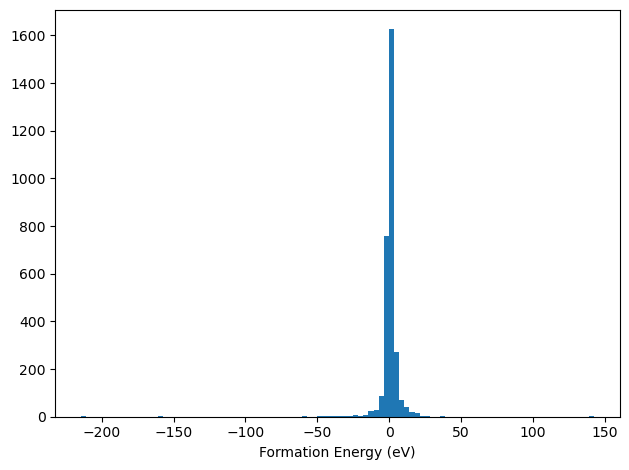

In [16]:
plt.figure()
plt.hist(list(target_property.values()),bins=100)
plt.xlabel('Formation Energy (eV)')

plt.tight_layout()

---- 
Too long descriptor. Let's shorten it. 

In [17]:

# Split data into features (X) and target (y)
X = df.drop(columns='target')
y = df['target']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r_sq = model.score(X_test, y_test)
print("R^2:", r_sq)


KeyError: "['target'] not found in axis"

In [18]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

df_target = pd.Series(target_property, name='target')
df_descriptors = pd.DataFrame(descriptors).T

df = df_descriptors.join(df_target, how='inner')

# Split data into features (X) and target (y)
X = df.drop(columns='target')
y = df['target']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List of models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42),
    "Support Vector Regressor": SVR(kernel="linear"),
    "k-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
}

# Store results
results = {}

# Iterate over models
for model_name, model in models.items():
    # Optional: Use PCA for dimensionality reduction if needed
    pipeline = Pipeline([
        ('pca', PCA(n_components=5)),  # Adjust n_components based on explained variance
        ('regressor', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    
    # Store the results
    results[model_name] = mse
    print(f"{model_name} Mean Squared Error: {mse}")

# Display results
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Mean Squared Error"])
results_df = results_df.sort_values(by="Mean Squared Error", ascending=True)
print("\nModel Performance Comparison:")
print(results_df)


Linear Regression Mean Squared Error: 77.89116896851296
Ridge Regression Mean Squared Error: 77.8963125749646
Lasso Regression Mean Squared Error: 78.09996077968366
Decision Tree Mean Squared Error: 85.01828223451597
Random Forest Mean Squared Error: 78.64882900892529
Gradient Boosting Mean Squared Error: 74.77290743711714


KeyboardInterrupt: 